### DS5110 Final Project Assignment

#### The Ed Squad
* Isaac Stevens (is3sb)<br>
* Jamie Oh (hso6b)<br>
* Ashlie Ossege (ajo5fs)<br>
* Shilpa Narayan (smn7ba)<br>

### Research question/hypothesis

Inspired by the question "How much has your ZIP Code Determined Your Opportunities" , posed in the Student Opinion section of NY Times<sup>1</sup>, The Ed Squad seeks to answer the question:

<b>What factors of a household contribute to completing education?</b></br>

Specifically, we hypothesize that Public Use Microdata Areas(PUMA) will be one of the leading indictors of whether or not one is predicted to complete their education. Our census data source from Ipums.org does not contain zipcode identifiers in public-use data, which is why we are looking at the most granular geographic factor our dataset has available.
    
H<sub>0</sub> = B<sub>puma</sub> = 0 <br>
H<sub>a</sub> = B<sub>puma</sub> ne 0


### Data Sources

Our data comes from the American Community Survey 2015-2019 Sample from usa.ipsums.org. and contains households and person information such as age, income, health insurance, and other demographic variables. In total there are 194 variables. Our focus of the study is in the South Region.

Data: https://usa.ipums.org/usa/sampdesc.shtml#us2019c </br>
Code Book for variables in the data: https://github.com/narashil/DS-5110-Project/blob/main/usa_00001.cbk


### Supplemental Sources
<sup>1</sup>  https://www.nytimes.com/2020/05/19/learning/how-much-has-your-zip-code-determined-your-opportunities.html </br>
<sup>2</sup> https://www.census.gov/programs-surveys/geography/guidance/geo-areas/pumas.html 

In [1]:
# load modules
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA


# set up the session
spark = SparkSession.builder.getOrCreate()

In [2]:
%matplotlib inline 

In [3]:
df = spark.read.csv('acs_15_19_south.csv', inferSchema=True, header=True)

In [4]:
def EDUCFunc(value):
  if   value > 6: 
      return 1
  else:
      return 0

#create the function to be applied and create a new column EDUC_FLAG
udfsomefunc = F.udf(EDUCFunc, IntegerType())
df = df.withColumn("EDUC_FLAG", udfsomefunc("EDUC"))
#see sample data
df.select('EDUC_FLAG').show(5)

+---------+
|EDUC_FLAG|
+---------+
|        0|
|        1|
|        0|
|        1|
|        0|
+---------+
only showing top 5 rows



In [9]:
#df.show(3)

In [11]:
#df.columns

## EDA

In [5]:
df.count(), len(df.columns)

(5965249, 206)

In [14]:
#df.head()

In [24]:
#df.printSchema()

In [ ]:
'''
EDUC                Educational attainment [general version]
00                  N/A or no schooling
01                  Nursery school to grade 4
02                  Grade 5, 6, 7, or 8
03                  Grade 9
04                  Grade 10
05                  Grade 11
06                  Grade 12
07                  1 year of college
08                  2 years of college
09                  3 years of college
10                  4 years of college
11                  5+ years of college
'''

In [6]:
df.select('EDUC').distinct().orderBy('EDUC').show()

+----+
|EDUC|
+----+
|   0|
|   1|
|   2|
|   3|
|   4|
|   5|
|   6|
|   7|
|   8|
|  10|
|  11|
+----+



In [25]:
#type('EDUC')

In [7]:
df_edu = df.groupby('EDUC').count().orderBy('EDUC')
df_edu.show()

+----+-------+
|EDUC|  count|
+----+-------+
|   0| 360318|
|   1| 456253|
|   2| 417958|
|   3| 147906|
|   4| 163885|
|   5| 172998|
|   6|1775804|
|   7| 719456|
|   8| 368279|
|  10| 850738|
|  11| 531654|
+----+-------+



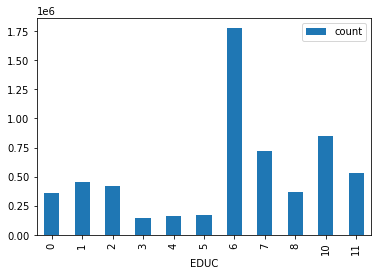

In [8]:
import matplotlib.pyplot as plt
df_edu = df_edu.toPandas()
df_edu.plot(x="EDUC", y="count", kind='bar')
plt.show() # no 9's!

### Education Flag Ratio

In [9]:
e_0 = df.filter(df['EDUC_FLAG'] == 0).count()
e_1 = df.filter(df['EDUC_FLAG'] == 1).count()
e_0/(e_0+e_1), e_1/(e_0+e_1) 

(0.5859138486926531, 0.41408615130734694)

### Gender

In [ ]:
'''
SEX                 Sex
1                   Male
2                   Female
'''

In [10]:
df.groupBy('SEX').count().show()

+---+-------+
|SEX|  count|
+---+-------+
|  1|2897686|
|  2|3067563|
+---+-------+



In [11]:
male_0 = df[(df['SEX'] == 1) & (df['EDUC_FLAG'] == 0)].count()
male_1 = df[(df['SEX'] == 1) & (df['EDUC_FLAG'] == 1)].count()
female_0 = df[(df['SEX'] == 2) & (df['EDUC_FLAG'] == 0)].count()
female_1 = df[(df['SEX'] == 2) & (df['EDUC_FLAG'] == 1)].count()
male = male_0 + male_1
female = female_0 + female_1
total = male + female
total, df.count()

(5965249, 5965249)

In [12]:
# Male - Ed 0 vs Ed 1
male_0/(male_0+male_1), male_1/(male_0+male_1)

(0.6060601459233333, 0.3939398540766667)

In [13]:
# Female - Ed 0 vs Ed 1
female_0/(female_0+female_1), female_1/(female_0+female_1)

(0.5668832229362527, 0.43311677706374735)

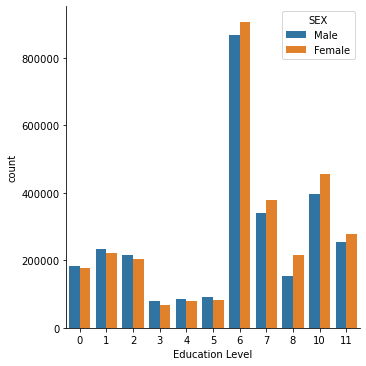

In [14]:
import seaborn as sns
df2 = df.groupBy('EDUC', 'SEX').count().orderBy('EDUC', 'SEX')
df2 = df2.toPandas()
fg = sns.catplot(x='EDUC', y='count', hue='SEX', data=df2, kind='bar', legend_out=False)
fg.set_xlabels('Education Level')

new_labels = ['Male', 'Female']
for old, new in zip(fg._legend.texts, new_labels): old.set_text(new)

#https://stackoverflow.com/questions/31845258/pandas-multi-index-plotting

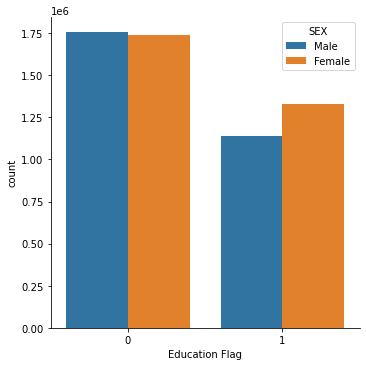

In [15]:
df3 = df.groupBy('EDUC_FLAG', 'SEX').count().orderBy('EDUC_FLAG', 'SEX')
df3 = df3.toPandas()
fg = sns.catplot(x='EDUC_FLAG', y='count', hue='SEX', data=df3, kind='bar', legend_out=False)
fg.set_xlabels('Education Flag')

new_labels = ['Male', 'Female']
for old, new in zip(fg._legend.texts, new_labels): old.set_text(new)

 ## Sample: 2019 Data

In [16]:
sample = df.filter(df['MULTYEAR'] == 2019)
sample.count()

1217644

In [26]:
sample.count()/df.count()

0.2041229125557039

## Logistic Regression Model

### with all features

In [17]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[column for column in sample.columns if column not in ['EDUC','EDUC_FLAG']], outputCol="features") 
tr = assembler.transform(sample)

In [18]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(tr)
scaledData = scalerModel.transform(tr)

In [19]:
training, test = scaledData.randomSplit([0.7, 0.3], seed=314)

In [20]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='EDUC_FLAG',
                        featuresCol='scaledFeatures',
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)

# Fit the model excluding intercept
lrModel = lr.fit(training)

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# compute predictions. this will append column "prediction" to dataframe
lrPred = lrModel.transform(test)

# set up evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",
                                          labelCol="EDUC_FLAG",
                                          metricName="accuracy")

evaluator2 = BinaryClassificationEvaluator(rawPredictionCol="prediction",
                                          labelCol="EDUC_FLAG",
                                          metricName="areaUnderPR")


# pass to evaluator the DF with predictions, labels
accuracy = evaluator.evaluate(lrPred)
aupr = evaluator2.evaluate(lrPred)


print("The model accuracy is:", accuracy)
print("Area under PR Curve:", aupr)

The model accuracy is: 0.8187826600564946
Area under PR Curve: 0.8779862703618915


### with ROI

In [22]:
roi = ["HHTYPE","REGION","STATEFIP","COUNTYFIP","METRO","COSTELEC","COSTGAS","COSTWATR","COSTFUEL","FOODSTMP",
       "CINETHH","CILAPTOP", "CISMRTPHN","CITABLET","VEHICLES","COUPLETYPE","NFAMS","NMOTHERS","NFATHERS",
       "CITIZEN","YRSUSA1","RACAMIND","RACASIAN","RACBLK","RACPACIS" ,"RACWHT","RACOTHER","HCOVANY","EMPSTAT",
       "LABFORCE","CLASSWKR","UHRSWORK","VETSTAT","TRANWORK","GCHOUSE","MULTYEAR","EDUC_FLAG"]

In [23]:
sample_roi = sample.select(roi)

In [24]:
assembler2 = VectorAssembler(inputCols=[column for column in roi if column not in ["MULTYEAR", "EDUC_FLAG"]], outputCol="features") 
tr2 = assembler2.transform(sample_roi)

scaler2 = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel2 = scaler2.fit(tr2)
scaledData2 = scalerModel2.transform(tr2)

training, test = scaledData2.randomSplit([0.7, 0.3], seed=314)

lr2 = LogisticRegression(labelCol='EDUC_FLAG',
                        featuresCol='scaledFeatures',
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)

lrModel2 = lr2.fit(training)

lrPred2 = lrModel2.transform(test)

# set up evaluator
evaluator_2 = MulticlassClassificationEvaluator(predictionCol="prediction",
                                          labelCol="EDUC_FLAG",
                                          metricName="accuracy")

evaluator2_2 = BinaryClassificationEvaluator(rawPredictionCol="prediction",
                                          labelCol="EDUC_FLAG",
                                          metricName="areaUnderPR")


# pass to evaluator the DF with predictions, labels
accuracy2 = evaluator_2.evaluate(lrPred2)
aupr2 = evaluator2_2.evaluate(lrPred2)


print("The model accuracy is:", accuracy2)
print("Area under PR Curve:", aupr2)

The model accuracy is: 0.5729794174990908
Area under PR Curve: 0.42702058250090924


In [35]:
TN = lrPred2.filter('prediction = 0 AND EDUC_FLAG = prediction').count()
TP = lrPred2.filter('prediction = 1 AND EDUC_FLAG = prediction').count()
FN = lrPred2.filter('prediction = 0 AND EDUC_FLAG <> prediction').count()
FP = lrPred2.filter('prediction = 1 AND EDUC_FLAG <> prediction').count()
 
lrPred2.groupBy('EDUC_FLAG', 'prediction').count().show()

accuracy = (TN + TP) / (TN + TP + FN + FP)
  
print('accuracy: %0.3f' % accuracy)

+---------+----------+------+
|EDUC_FLAG|prediction| count|
+---------+----------+------+
|        1|       0.0|156161|
|        0|       0.0|209538|
+---------+----------+------+

accuracy: 0.573


### ROI with PCA

In [72]:
# PCA using 10 components
pca = PCA(k=10, inputCol=assembler2.getOutputCol(), outputCol="pcaFeatures")
pca_model = pca.fit(scaledData2)

# extract the transformed features
pca_result = pca_model.transform(scaledData2)

training, test = pca_result.randomSplit([0.7, 0.3], seed=314)

lr_pca = LogisticRegression(labelCol='EDUC_FLAG',
                        featuresCol='pcaFeatures',
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)

lrModel_pca = lr_pca.fit(training)

lrPred_pca = lrModel_pca.transform(test)

# set up evaluator
evaluator_3 = MulticlassClassificationEvaluator(predictionCol="prediction",
                                          labelCol="EDUC_FLAG",
                                          metricName="accuracy")

evaluator2_3 = BinaryClassificationEvaluator(rawPredictionCol="prediction",
                                          labelCol="EDUC_FLAG",
                                          metricName="areaUnderPR")


# pass to evaluator the DF with predictions, labels
accuracy3 = evaluator_3.evaluate(lrPred_pca)
aupr3 = evaluator2_3.evaluate(lrPred_pca)


print("The model accuracy is:", accuracy3)
print("Area under PR Curve:", aupr3)

The model accuracy is: 0.5729794174990908
Area under PR Curve: 0.42702058250090924


### Pipeline

In [77]:
assembler = VectorAssembler(inputCols=[column for column in roi if column not in ["MULTYEAR", "EDUC_FLAG"]], outputCol="features") 
pca = PCA(k=10, inputCol=assembler.getOutputCol(), outputCol="pcaFeatures")
lr = LogisticRegression(labelCol='EDUC_FLAG',
                        featuresCol='pcaFeatures',
                        maxIter=10, 
                        regParam=0.3, 
                        elasticNetParam=0.8)

pipeline = Pipeline(stages=[assembler,pca,lr])

training, test = sample_roi.randomSplit([0.7, 0.3], seed=314)
model = pipeline.fit(training)
prediction = model.transform(test)
#prediction.show()

In [78]:
TN = prediction.filter('prediction = 0 AND EDUC_FLAG = prediction').count()
TP = prediction.filter('prediction = 1 AND EDUC_FLAG = prediction').count()
FN = prediction.filter('prediction = 0 AND EDUC_FLAG <> prediction').count()
FP = prediction.filter('prediction = 1 AND EDUC_FLAG <> prediction').count()
 
prediction.groupBy('EDUC_FLAG', 'prediction').count().show()

accuracy = (TN + TP) / (TN + TP + FN + FP)
  
print('accuracy: %0.3f' % accuracy)

+---------+----------+------+
|EDUC_FLAG|prediction| count|
+---------+----------+------+
|        1|       0.0|156161|
|        0|       0.0|209538|
+---------+----------+------+

accuracy: 0.573
